<a href="https://colab.research.google.com/github/SiddhantSalvi/smart-plug/blob/master/3DReconstructionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro and Setup

Welcome to the Google Colab for the Unity ML test! This template is *purely optional* and intended to provide a way to run your code with a GPU if you don't have access to one. Note that we are *not* grading for performance, so if you'd like to run with a CPU locally, that is an option. You may dramatically reduce the number of frames you convert to 3D to do so.

This section will set up the environment so that you can run the test files and clone your repo. 

## Getting the test files uploaded

First, let's upload the zip file provided in the test to the Colab, and unzip it. Run the following code, click the "Choose Files", and pick the ZIP file. After the files finish unzipping, you should see 3 MP4 files,
- FigureSkater.mp4
- JumpingJacks.mp4
- Skateboarder.mp4


In [1]:
# downloading all the dependencies
# Takes approximately 5 mins to run
!pip install torch==1.4.0 torchvision==0.5.0
!pip install open3D
!pip install PyOpenGL PyOpenGL_accelerate

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-hfptthpt
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-hfptthpt
  Running command git checkout -q 3fc3ea507bfbf7e1c2d5023a6db202698206f91d
  Using cached fvcore-0.1.5.post20211023.tar.gz (49 kB)
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached portalocker-2.3.2-py2.py3-none-any.whl (15 kB)
  Created wheel for pytorch3d: filename=pytorch3d-0.6.1-cp37-cp37m-linux_x86_64.whl size=23728433 sha256=4d269642e0bf64180040946e1f394ae9db2c64e53aba762e589299f76e8fd0c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-pkc2a7cr/wheels/4c/03/f0/326bb241eb86a155a12f217c81e163fbba48424bb84fa22074
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60944 sha256=7ff6f1a559f4817cf2d93405241be7e281466e0a2619557a96f8eb9b9247cac2
  Stored in directory: 

In [2]:
# converting the video into image frames
import cv2
import numpy as np
import OpenGL
# replace the file with another video
vid_cap = cv2.VideoCapture("FigureSkater.mp4") 
def getFrame(sec):
    vid_cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    has_frames,image = vid_cap.read()
    if has_frames:
        image = cv2.resize(image,(512,512))
        cv2.imwrite("image"+str(count)+".jpg", image)     # save frame as JPG file
    return has_frames
sec = 0
frameRate = 0.7 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
print(count)

7


In [3]:
# generating mask of the image using the primitive techniques openCV inbuilt functionns.
for i in range(1,count):
  image = cv2.imread("image" + str(i)+ ".jpg")
  mask = np.zeros(image.shape[:2], dtype="uint8")
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  mask = cv2.threshold(gray,220,220, cv2.THRESH_BINARY)[1]

  # negate mask
  mask = 255 - mask

  # apply morphology to remove isolated extraneous noise
  # use borderconstant of black since foreground touches the edges
  kernel = np.ones((3,3), np.uint8)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

  # anti-alias the mask -- blur then stretch
  # blur alpha channel
  mask = cv2.GaussianBlur(mask, (0,0), sigmaX=2, sigmaY=2, borderType = cv2.BORDER_DEFAULT)
  mask = (2*(mask.astype(np.float32))-255.0).clip(0,255).astype(np.uint8)

  # resize opencv windows
  mask=cv2.resize(mask,(512,512))

  cv2.imwrite("mask"+str(i)+".jpg",mask)

(512, 512, 3)


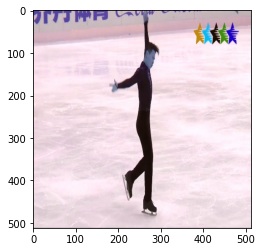

In [4]:
import matplotlib.pyplot as plt
image = cv2.imread("image3.jpg")
image = cv2.resize(image,(512,512))
plt.figure()
plt.imshow(image)
print(image.shape)


## Clone your repo from Github

Now let's download your Github repo. This can be done using the steps below. 

In [5]:
# cloning the required repositories
!git clone https://github.com/SiddhantSalvi/pifuhd.git
!git clone https://github.com/SiddhantSalvi/PIFu.git
!git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git


Cloning into 'pifuhd'...
remote: Enumerating objects: 213, done.
remote: Total 213 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (213/213), 402.76 KiB | 13.42 MiB/s, done.
Resolving deltas: 100% (104/104), done.
Cloning into 'PIFu'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 215 (delta 2), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (215/215), 2.43 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Cloning into 'lightweight-human-pose-estimation.pytorch'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 120 (delta 1), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (120/120), 228.43 KiB | 8.79 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [8]:
# training the model using the pretained weights 
%cd /content/PIFu


/content/PIFu


In [9]:
!sh ./scripts/download_trained_model.sh

+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://drive.google.com/uc?export=download&id=1zEmVXG2VHy0MMzngcRshB4D8Sr_oLHsm -O net_G
--2022-01-18 19:38:40--  https://drive.google.com/uc?export=download&id=1zEmVXG2VHy0MMzngcRshB4D8Sr_oLHsm
Resolving drive.google.com (drive.google.com)... 74.125.142.102, 74.125.142.100, 74.125.142.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eq08r4d5j5giif7o39e3mo8cge99al8i/1642534650000/14428417455748421393/*/1zEmVXG2VHy0MMzngcRshB4D8Sr_oLHsm?e=download [following]
--2022-01-18 19:38:41--  https://doc-14-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eq08r4d5j5giif7o39e3mo8cge99al8i/1642534650000/14428417455748421393/*/1zEmVXG2VHy0MMzngcRshB4D8Sr_oLHsm?e=download
Resolving doc-14-0o-docs.googleusercontent.com (d

In [12]:
# writing the directory of the images to test the image frames!
# if using different video, will have to write the same lines below, for all the images to be tested
!python3 /content/PIFu/apps/crop_img.py -i /content/image1.jpg -m /content/mask1.jpg -o /content/PIFu/sample_images/ 
!python3 /content/PIFu/apps/crop_img.py -i /content/image2.jpg -m /content/mask2.jpg -o /content/PIFu/sample_images/
!python3 /content/PIFu/apps/crop_img.py -i /content/image3.jpg -m /content/mask3.jpg -o /content/PIFu/sample_images/
!python3 /content/PIFu/apps/crop_img.py -i /content/image4.jpg -m /content/mask4.jpg -o /content/PIFu/sample_images/
!python3 /content/PIFu/apps/crop_img.py -i /content/image5.jpg -m /content/mask5.jpg -o /content/PIFu/sample_images/
!python3 /content/PIFu/apps/crop_img.py -i /content/image6.jpg -m /content/mask6.jpg -o /content/PIFu/sample_images/
#!python3 /content/PIFu/apps/crop_img.py -i /content/image7.jpg -m /content/mask7.jpg -o /content/PIFu/sample_images/
#!python3 /content/PIFu/apps/crop_img.py -i /content/image8.jpg -m /content/mask8.jpg -o /content/PIFu/sample_images/
#!python3 /content/PIFu/apps/crop_img.py -i /content/image9.jpg -m /content/mask9.jpg -o /content/PIFu/sample_images/

In [13]:
# running this cell generates the object files of the images given as input to the previous cell
# the results are stored in the PIFu/result/folder

!sh ./scripts/test.sh

+ GPU_ID=0
+ DISPLAY_ID=10
+ NAME=pifu_demo
+ BATCH_SIZE=1
+ MLP_DIM=257 1024 512 256 128 1
+ MLP_DIM_COLOR=513 1024 512 256 128 3
+ VOL_RES=256
+ CHECKPOINTS_NETG_PATH=./checkpoints/net_G
+ CHECKPOINTS_NETC_PATH=./checkpoints/net_C
+ TEST_FOLDER_PATH=./sample_images
+ CUDA_VISIBLE_DEVICES=0 python ./apps/eval.py --name pifu_demo --batch_size 1 --mlp_dim 257 1024 512 256 128 1 --mlp_dim_color 513 1024 512 256 128 3 --num_stack 4 --num_hourglass 2 --resolution 256 --hg_down ave_pool --norm group --norm_color group --test_folder_path ./sample_images --load_netG_checkpoint_path ./checkpoints/net_G --load_netC_checkpoint_path ./checkpoints/net_C
initialize network with normal
Using Network:  hgpifu
loading for net C ... ./checkpoints/net_C
initialize network with normal
num;  7
0it [00:00, ?it/s]./sample_images/image1.png ./sample_images/image1_mask.png
/content/PIFu/lib/mesh_util.py:45: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner 

In [15]:
# This cell takes approximately 20 mins to run
#pytorch3D for 3D model generation
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-dd8r84u5
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-dd8r84u5
  Running command git checkout -q 3fc3ea507bfbf7e1c2d5023a6db202698206f91d
     |████████████████████████████████| 49 kB 3.7 MB/s 
     |████████████████████████████████| 596 kB 14.7 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.1-cp37-cp37m-linux_x86_64.whl size=30536233 sha256=91d6baca5c6662ac8c490e6e9bb30a099741212845efbc1728111e45896de610
  Stored in directory: /tmp/pip-ephem-wheel-cache-egemz2bp/wheels/4c/03/f0/326bb241eb86a155a12f217c81e163fbba48424bb84fa22074
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60944 sha256=0275d5f5a6d506b18594a2352506191dafd9fa05d79c8bb912d87a5e00030ad1
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built pytor

In [16]:
# running this cell would produce the output generated using PIFu.
# a rendered video is displayed.
from lib.colab_util import *
for i in range(1,count):
  obj_path = '/content/PIFu/results/pifu_demo/result_image'+str(i)+'.obj'
  video_path = '/content/PIFu/results/pifu_demo/result_image'+str(i)+'.mp4'
  video_display_path = '/content/PIFu/results/pifu_demo/result_image'+str(i)+'_display.mp4'

  renderer = set_renderer()
  generate_video_from_obj(obj_path, video_path, renderer)

# we cannot play a mp4 video generated by cv2
  !ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
  video(video_display_path)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [17]:
# improving the results using PIFu HD as it uses multilevel pixel allignment technique over PIFu!
# the code is as follows:

In [18]:
cd /content/pifuhd/sample_images

/content/pifuhd/sample_images


In [25]:
import os

try:
  image_path = '/content/PIFu/sample_images/image1.png'#'/content/pifuhd/sample_images/image1.jpg' #% image1.jpg or other image frames can be included one at a time
except:
  image_path = '/content/pifuhd/sample_images/test.png' # example image
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output pathes
obj_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.png' % file_name
video_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/pifuhd/results/pifuhd_final/result_%s_256_display.mp4' % file_name


In [26]:
cd /content

/content


In [27]:
cd /content/lightweight-human-pose-estimation.pytorch/

/content/lightweight-human-pose-estimation.pytorch


In [28]:
!wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

--2022-01-18 20:16:50--  https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth
Resolving download.01.org (download.01.org)... 104.65.185.105, 2600:1409:9800:a85::4b21, 2600:1409:9800:a92::4b21
Connecting to download.01.org (download.01.org)|104.65.185.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87959810 (84M) [application/octet-stream]
Saving to: ‘checkpoint_iter_370000.pth.1’

checkpoint_iter_370 100%[===================>]  83.88M   150MB/s    in 0.6s    

2022-01-18 20:16:50 (150 MB/s) - ‘checkpoint_iter_370000.pth.1’ saved [87959810/87959810]



In [29]:
# detecting the keypoints in the images to generate the 3D models
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=False)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)
            
            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(np.int)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')

In [30]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net.cuda(), [image_path], 512)

In [31]:
cd /content/pifuhd/

/content/pifuhd


In [32]:
!sh ./scripts/download_trained_model.sh

+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt pifuhd.pt
--2022-01-18 20:17:04--  https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548375177 (1.4G) [application/octet-stream]
Saving to: ‘pifuhd.pt’

pifuhd.pt           100%[===================>]   1.44G  48.6MB/s    in 30s     

2022-01-18 20:17:35 (49.1 MB/s) - ‘pifuhd.pt’ saved [1548375177/1548375177]

--2022-01-18 20:17:35--  http://pifuhd.pt/
Resolving pifuhd.pt (pifuhd.pt)... failed: Name or service not known.
wget: unable to resolve host address ‘pifuhd.pt’
FINISHED --2022-01-18 20:17:35--
Total wall clock time: 31s
Downloaded: 1 files, 1.4G in 30s (49.1 MB/s)


In [33]:
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

Resuming from  ./checkpoints/pifuhd.pt
test data size:  1
initialize network with normal
initialize network with normal
generate mesh (test) ...
  0% 0/1 [00:00<?, ?it/s]./results/pifuhd_final/recon/result_image1_256.obj
/content/pifuhd/lib/mesh_util.py:77: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(sdf, thresh)
100% 1/1 [00:06<00:00,  6.83s/it]


Most of the common ML libraries (PyTorch, numpy, TensorFlow, etc) should already be available. You can install other versions using pip as usual, e.g. `!pip install <library>`.

You can also use `!cd <directory>` to get into a directory.

# Run your code

Running your code is as simple as using the "!" operator in front of what you'd normally run locally. For instance, the below line assumes your main Python file is called `convert.py` and takes in as an argument the video file. You can then run:

In [36]:
# generates the output video
# less noisy rendered output as compared to the base model.
from lib.colab_util import *

renderer = set_renderer()
generate_video_from_obj(obj_path,  video_path, renderer)#out_img_path,

# we cannot play a mp4 video generated by cv2
!ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
video(video_display_path)

  0%|          | 0/90 [00:00<?, ?it/s]

## Downloading results
You can download any results from the left sidebar. Click the folder icon; the results saved here should be found in the `/content/` directory.